In [9]:
from datasets import load_dataset
from torch.utils.data import DataLoader
from fastprogress.fastprogress import master_bar, progress_bar
from time import sleep
import numpy as np
import random

In [26]:
imagenet_train = load_dataset("danjacobellis/imagenet_dino",split='train[:128]').with_format("torch")
imagenet_valid = load_dataset("danjacobellis/imagenet_dino",split='validation[:128]').with_format("torch")

Resolving data files:   0%|          | 0/41 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/41 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/41 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/41 [00:00<?, ?it/s]

In [7]:
def plot_loss_update(epoch, epochs, mb, train_loss, valid_loss):
    """ dynamically print the loss plot during the training/validation loop.
        expects epoch to start from 1.
    """
    x = range(1, epoch+1)
    y = np.concatenate((train_loss, valid_loss))
    graphs = [[x,train_loss], [x,valid_loss]]
    x_margin = 0.2
    y_margin = 0.05
    x_bounds = [1-x_margin, epochs+x_margin]
    y_bounds = [np.min(y)-y_margin, np.max(y)+y_margin]

    mb.update_graph(graphs, x_bounds, y_bounds)

In [ ]:
class RateDistortionAutoEncoder(CompressionModel):
    def __init__(self, N=128):
        super().__init__()
        self.entropy_bottleneck = EntropyBottleneck(N)
        self.encode = nn.Sequential(
            conv(3, N),
            GDN(N),
            conv(N, N),
            GDN(N),
            conv(N, N),
        )

        self.decode = nn.Sequential(
            deconv(N, N),
            GDN(N, inverse=True),
            deconv(N, N),
            GDN(N, inverse=True),
            deconv(N, 3),
        )

    def forward(self, x):
        y = self.encode(x)
        y_hat, y_likelihoods = self.entropy_bottleneck(y)
        x_hat = self.decode(y_hat)
        return x_hat, y_likelihoods

In [ ]:
net = RateDistortionAutoEncoder().to("cuda")
parameters = set(p for n, p in net.named_parameters() if not n.endswith(".quantiles"))
aux_parameters = set(p for n, p in net.named_parameters() if n.endswith(".quantiles"))
optimizer = optim.Adam(parameters, lr=1e-4)
aux_optimizer = optim.Adam(aux_parameters, lr=1e-3)
λ = 0.01

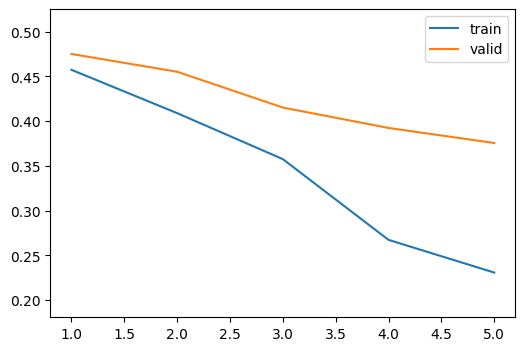

In [29]:
epochs = 5
mb = master_bar(range(1, epochs+1))
# optional: graph legend: if not set, the default is 'train'/'valid'
# mb.names = ['first', 'second']
train_loss, valid_loss = [], []
for epoch in mb:
    
    dataloader = DataLoader(imagenet_train, batch_size=32, shuffle=True)
    for batch in progress_bar(dataloader, parent=mb):
        x = batch['patch_tokens'][0].reshape((32,16,16,1536)).permute((0,3,1,2))

    
    train_loss.append(0.5 - 0.06 * epoch + random.uniform(0, 0.04))
    dataloader = DataLoader(imagenet_valid, batch_size=32, shuffle=True)
    for batch in progress_bar(dataloader, parent=mb):
        x = batch['patch_tokens'][0].reshape((32,16,16,1536)).permute((0,3,1,2))
    
    
    valid_loss.append(0.5 - 0.03 * epoch + random.uniform(0, 0.04))
    plot_loss_update(epoch, epochs, mb, train_loss, valid_loss)

In [69]:
x = batch['patch_tokens'].reshape((32,16,16,1536)).permute((0,3,1,2))
x = (x-x.mean())/x.std()
x = x.clamp(-3,3)
x = x/6 + 0.5
x = 255*x
x = x.round()
x = x.to(torch.uint8)

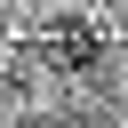

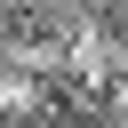

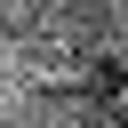

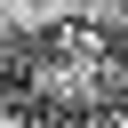

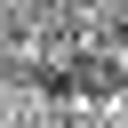

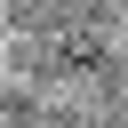

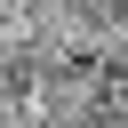

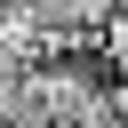

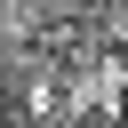

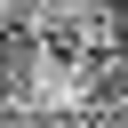

In [70]:
for c in range(10):
    display(ToPILImage()(x[0,c,:,:]).resize((128,128)))